# 05_nndl

We will experiment with Neural Networks and Deep Learning on our original dataset. No PCA yet

In [21]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

In [22]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [23]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [24]:
# check shape
print(train.shape)
print(test.shape)

(280145, 138)
(120504, 138)


In [25]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [26]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Helper functions

In [27]:
# constants
SEED = 42

In [28]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [29]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history

  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot losses
    train_loss = history['loss']
    # val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    # ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # # plot iou_score
    # iou_score = history['iou_score']
    # # val_iou_score = history['val_iou_score']
    # iou_score_title = 'iou_score against epochs'

    # ax2.plot(iou_score, label='train')
    # # ax2.plot(val_iou_score, label='val')
    # ax2.set_title(iou_score_title)
    # ax2.set_ylabel('iou_score')
    # ax2.set_xlabel('epochs')
    # ax2.legend()

    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural network

In [30]:
!pip install keras_tqdm

In [31]:
# import tensorflow as tf
# import tensorflow.keras as keras
# from keras_tqdm import TQDMCallback
# from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import tensorflow.keras as keras
from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.experimental.preprocessing import Normalization
from random import choices

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [32]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [33]:
# class UtilityScoreCallback(keras.callbacks.Callback):
#   def on_train_end(self):
#     print("End training")
#     print("shape_train: ", self.train.shape)

#   def on_test_end(self):
#     print("End testing")
#     print("shape_test: ", self.test.shape)

In [34]:
def create_mlp(num_columns, hidden_units, dropout_rates, label_smoothing, learning_rate): 
  inp = tf.keras.layers.Input(shape=(num_columns,))
  x = tf.keras.layers.BatchNormalization()(inp)
  x = tf.keras.layers.Dropout(dropout_rates[0])(x)
  for i in range(len(hidden_units)):
    x = tf.keras.layers.Dense(hidden_units[i])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(dropout_rates[i+1])(x)

  x = tf.keras.layers.Dense(1)(x)
  out = tf.keras.layers.Activation("sigmoid")(x)

  model = tf.keras.models.Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
    # metrics=[tf.keras.metrics.AUC(name="AUC")]
    metrics=[tf.keras.metrics.Accuracy()]
  )

  return model

In [35]:
# batch_size = 5000
# hidden_units = [150, 150, 150]
# dropout_rates = [0.2, 0.2, 0.2, 0.2]
# label_smoothing = 1e-2
# learning_rate = 1e-3

batch_size = 5000
hidden_units = [150, 150, 150]
dropout_rates = [0.2, 0.2, 0.2, 0.2]
label_smoothing = 1e-2
learning_rate = 1e-3

In [36]:
model = create_mlp(x_train.shape[1], hidden_units, dropout_rates, label_smoothing, learning_rate)
model_name = "nndl_model_test"
CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq=1)

In [50]:
# custom callback to evaluate the test set at each epoch
class UtilityScoreCallback(keras.callbacks.Callback):
    def __init__(self, test, x_test, y_test):
        self.test = test
        self.x_test = x_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs={}):
        y_pred = (self.model.predict(self.x_test) > 0.5).astype(int)
        print(utility_score(self.test, y_pred))

Epoch 1/100
57/57 [==============================] - 0s 9ms/step - loss: 0.6554 - accuracy: 0.0000e+00
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.0000e+00
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6563 - accuracy: 0.0000e+00
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6555 - accuracy: 0.0000e+00
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6555 - accuracy: 3.5696e-06
Epoch 6/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6554 - accuracy: 0.0000e+00
Epoch 7/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.0000e+00
Epoch 8/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6554 - accuracy: 0.0000e+00
Epoch 9/100
57/57 [==============================] - 0s 8ms/step - loss: 0.6550 - accuracy: 0.0000e+00
Epoch 10/100
57/57 [==============================] - 0s 8ms/step - loss:

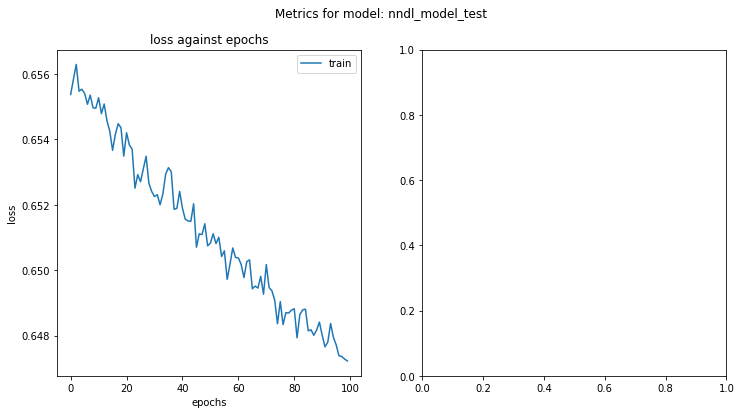

In [52]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=100, 
    batch_size=5000,
    # callbacks = [
    #              UtilityScoreCallback(test, x_test, y_test)
    # ]
)

history_saver(history, model_name, PATH_HISTORIES, already_npy=False)
history = history_loader(model_name, PATH_HISTORIES)
plot_metrics(history, model_name, PATH_FIGURES)

In [53]:
'''
predict on the test set. load best weights from checkpoints
'''
# model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

test_metrics = model.evaluate(x_test, steps=3)

test_metrics_dict = {
    'test_loss': test_metrics[0]
}

np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [57]:
y_pred = (model.predict(x_test) > 0.5).astype(int)
utility_score(test, y_pred)

2.555969960629928

In [56]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# Conclusion